In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("atifaliak/youtube-comments-dataset")

print("Path to dataset files:", path)

c:\Users\Saduddin\anaconda3\envs\Practice\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 1.20M/1.20M [00:01<00:00, 958kB/s]

Extracting files...
Path to dataset files: C:\Users\Saduddin\.cache\kagglehub\datasets\atifaliak\youtube-comments-dataset\versions\1


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize


from tqdm import trange
import spacy
from collections import Counter

import gensim
from gensim.corpora.dictionary import Dictionary
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


In [18]:
dataset = pd.read_csv("D:\Python_Practice\data\EDA\YoutubeCommentsDataSet.csv")

In [19]:
df = dataset

In [20]:
df.columns

Index(['Comment', 'Sentiment'], dtype='object')

In [21]:
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [22]:
len(df)

18408

Checking Sentiment distribution

In [23]:
print(df['Sentiment'].value_counts())

Sentiment
positive    11432
neutral      4638
negative     2338
Name: count, dtype: int64


checking average comment length

In [24]:
df['Comment_Length'] = df['Comment'].apply(lambda x: len(str(x).split()))
print(df.groupby('Sentiment')['Comment_Length'].describe())


             count       mean        std  min   25%   50%   75%     max
Sentiment                                                              
negative    2338.0  39.479042  49.348635  1.0  15.0  25.0  46.0   686.0
neutral     4638.0  35.591419  61.720650  1.0  11.0  18.0  37.0  1353.0
positive   11432.0  30.392232  35.188515  1.0  13.0  21.0  37.0  1005.0


In [25]:
df.head()

,Comment,Sentiment,Comment_Length
0,lets not forget that apple pay in 2014 require...,neutral,57
1,here in nz 50 of retailers don’t even have con...,negative,29
2,i will forever acknowledge this channel with t...,positive,31
3,whenever i go to a place that doesn’t take app...,negative,83
4,apple pay is so convenient secure and easy to ...,positive,26


Distribution

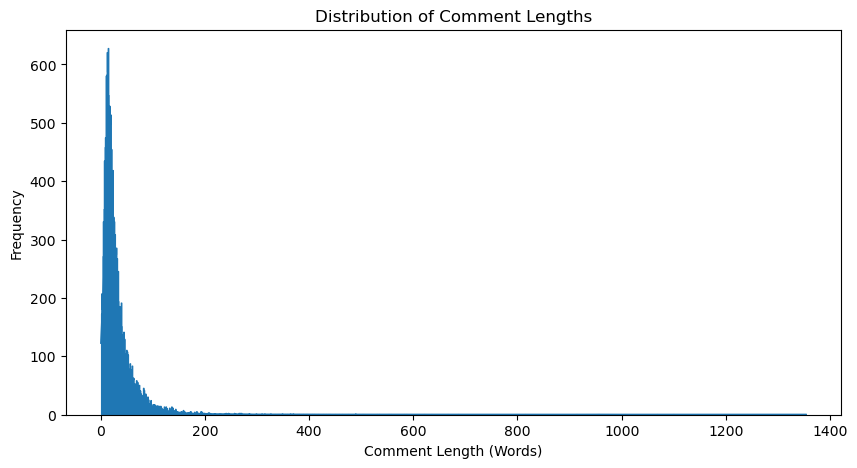

In [26]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Comment_Length'], bins=2000, kde=True,element='step')
plt.xlabel('Comment Length (Words)')
plt.ylabel('Frequency')
plt.title('Distribution of Comment Lengths')
plt.show()

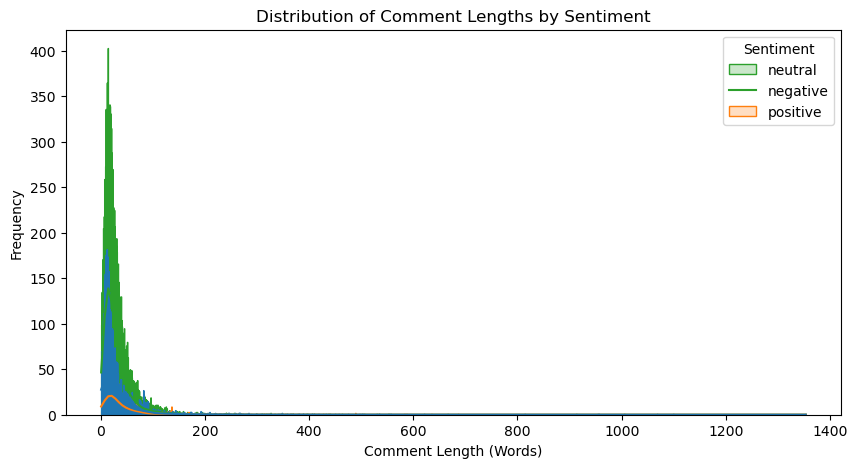

In [27]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='Comment_Length', bins=3000, kde=True, hue='Sentiment', element='step', common_norm=False)

plt.xlabel('Comment Length (Words)')
plt.ylabel('Frequency')
plt.title('Distribution of Comment Lengths by Sentiment')
plt.legend(title='Sentiment', labels=df['Sentiment'].unique(), fontsize=10)
plt.show()

In [28]:
print("Most Frequent Comment Length:", df['Comment_Length'].mode()[0])
for i in range(10,20):
    print(i,len(df[df['Comment_Length']==i]))
    

Most Frequent Comment Length: 14
10 580
11 582
12 621
13 588
14 628
15 547
16 510
17 529
18 499
19 514


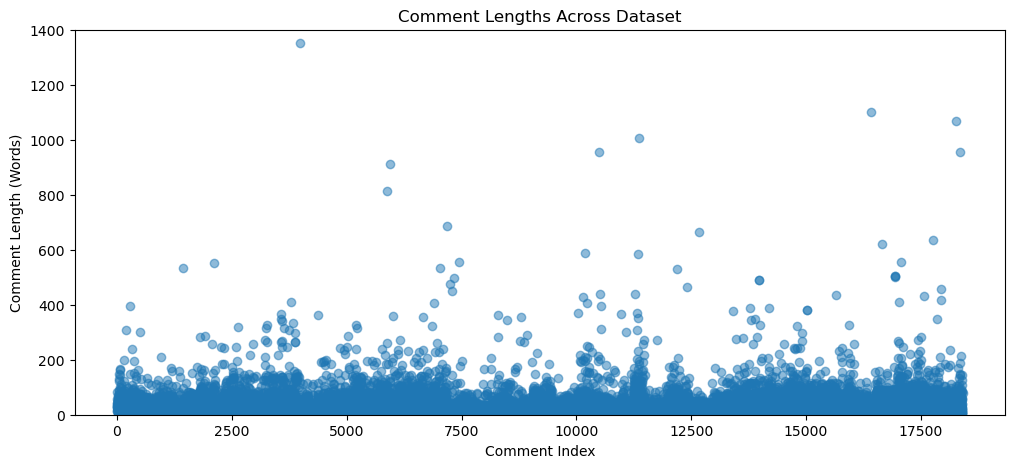

In [29]:
plt.figure(figsize=(12, 5))
plt.scatter(df.index, df['Comment_Length'], alpha=0.5)
plt.xlabel('Comment Index')
plt.ylabel('Comment Length (Words)')
plt.title('Comment Lengths Across Dataset')
plt.ylim(0, 1400)  # Set max limit near your longest comment
plt.show()


In [30]:
print("Shortest Comment:", df.loc[df['Comment_Length'].idxmin(), 'Comment'])
print("Longest Comment:", df.loc[df['Comment_Length'].idxmax(), 'Comment'])

Shortest Comment: cool 
Longest Comment: timestamps this took forever v2 001 intro ——————————— 035 original nxn 040 1x1 054 lanlan 2x2 110 rubik’s 3x3 125 rubik’s 4x4 138 rubik’s 5x5 154 vcube 6 208 vcube 7 226 vcube 8 251 mfjs mf8 8x8 302 mfjs mf9 9x9 312 yuxin huanglong 13x13 —————————————————— 324 main speedcubes 332 gan 251 m pro 340 gan 12 maglev 353 valk 4 m strong 401 valk 5 m 406 yj mgc 6x6 418 yuxin hays 7 m 431 xman volt square1 v2 m ud 446 gan skewb m enhanced 457 moyu weilong pyraminx maglev 508 yj yuhu megaminx v2 m 518 qiyi magnetic clock 531 rubik’s clock 541 rubik’s clock 2 554 intermission 610 giant 30cm 3x3 625 heshu super big 3x3 ————————————————— 643 shape mods cuboids 652 “brick” bandaged cube 707 “meffert’s” bandaged cube 719 cutter cube old 732 cutter cube 746 fisher cutter cube 804 octagonal barrel 813 3dprinted ghost cube 834 yj axis cube 845 rubik’s mirror cube 856 moyu crazy fisher cube 906 windmill cube ———————————————— 919 3dprinted 3x3 mods 932 2x2 octahed

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Comment         18364 non-null  object
 1   Sentiment       18408 non-null  object
 2   Comment_Length  18408 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 431.6+ KB


In [32]:
df.isnull().sum()

Comment           44
Sentiment          0
Comment_Length     0
dtype: int64

In [33]:
# Display rows where 'Comment' is null
df[df['Comment'].isnull()]


,Comment,Sentiment,Comment_Length
602,NaN,negative,1
716,NaN,neutral,1
812,NaN,positive,1
1021,NaN,positive,1
1023,NaN,neutral,1
1041,NaN,positive,1
1094,NaN,positive,1
2443,NaN,positive,1
3014,NaN,positive,1
3235,NaN,positive,1


In [34]:
df[df.isnull().any(axis=1)]


,Comment,Sentiment,Comment_Length
602,NaN,negative,1
716,NaN,neutral,1
812,NaN,positive,1
1021,NaN,positive,1
1023,NaN,neutral,1
1041,NaN,positive,1
1094,NaN,positive,1
2443,NaN,positive,1
3014,NaN,positive,1
3235,NaN,positive,1


Removing Null rows

In [35]:
df = df.dropna(subset=['Comment'])


In [36]:
# Display rows where 'Comment' is null
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 18364 entries, 0 to 18407
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Comment         18364 non-null  object
 1   Sentiment       18364 non-null  object
 2   Comment_Length  18364 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 573.9+ KB


Check Sentiment Distribution (Visualization)

C:\Users\Saad\AppData\Local\Temp\ipykernel_10972\1511040483.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Sentiment'], palette="coolwarm")


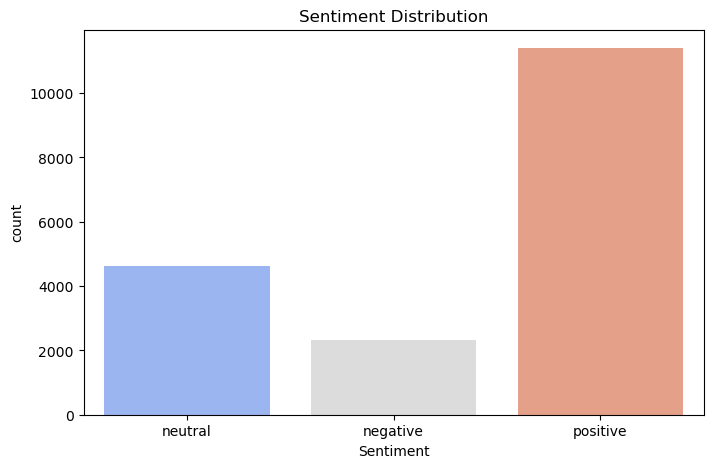

In [37]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df['Sentiment'], palette="coolwarm")
plt.title("Sentiment Distribution")
plt.show()

Text Length Analysis

C:\Users\Saad\AppData\Local\Temp\ipykernel_10972\1487352290.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Sentiment"], y=df["Comment_Length"], palette="coolwarm")


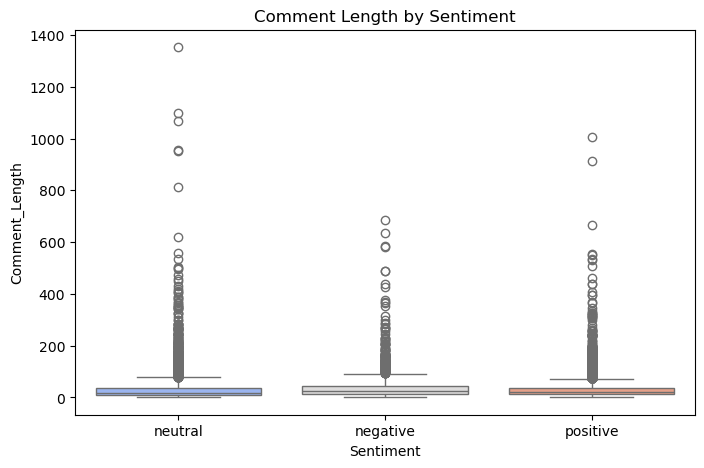

In [38]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df["Sentiment"], y=df["Comment_Length"], palette="coolwarm")
plt.title("Comment Length by Sentiment")
plt.show()


In [39]:
longestComment= df.loc[df['Comment_Length'].idxmax(), 'Comment']

Most common words

In [40]:
len(longestComment.split())

1353

In [41]:
df[df['Comment_Length']>1353]

,Comment,Sentiment,Comment_Length


character counts per sentence

In [42]:
df['character_count']=df['Comment'].apply(lambda x: len(x))

C:\Users\Saad\AppData\Local\Temp\ipykernel_10972\4209097898.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['character_count']=df['Comment'].apply(lambda x: len(x))


In [43]:
df.head()

,Comment,Sentiment,Comment_Length,character_count
0,lets not forget that apple pay in 2014 require...,neutral,57,317
1,here in nz 50 of retailers don’t even have con...,negative,29,163
2,i will forever acknowledge this channel with t...,positive,31,183
3,whenever i go to a place that doesn’t take app...,negative,83,450
4,apple pay is so convenient secure and easy to ...,positive,26,135


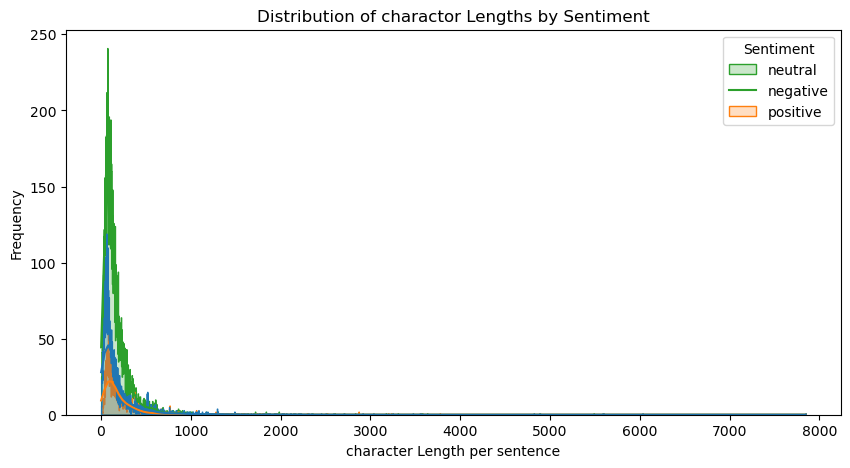

In [44]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='character_count', bins=3000, kde=True, hue='Sentiment', element='step', common_norm=False)

plt.xlabel('character Length per sentence')
plt.ylabel('Frequency')
plt.title('Distribution of charactor Lengths by Sentiment')
plt.legend(title='Sentiment', labels=df['Sentiment'].unique(), fontsize=10)
plt.show()

In [45]:
df.groupby('Sentiment')['character_count'].max()

Sentiment
negative    3775
neutral     7847
positive    5487
Name: character_count, dtype: int64

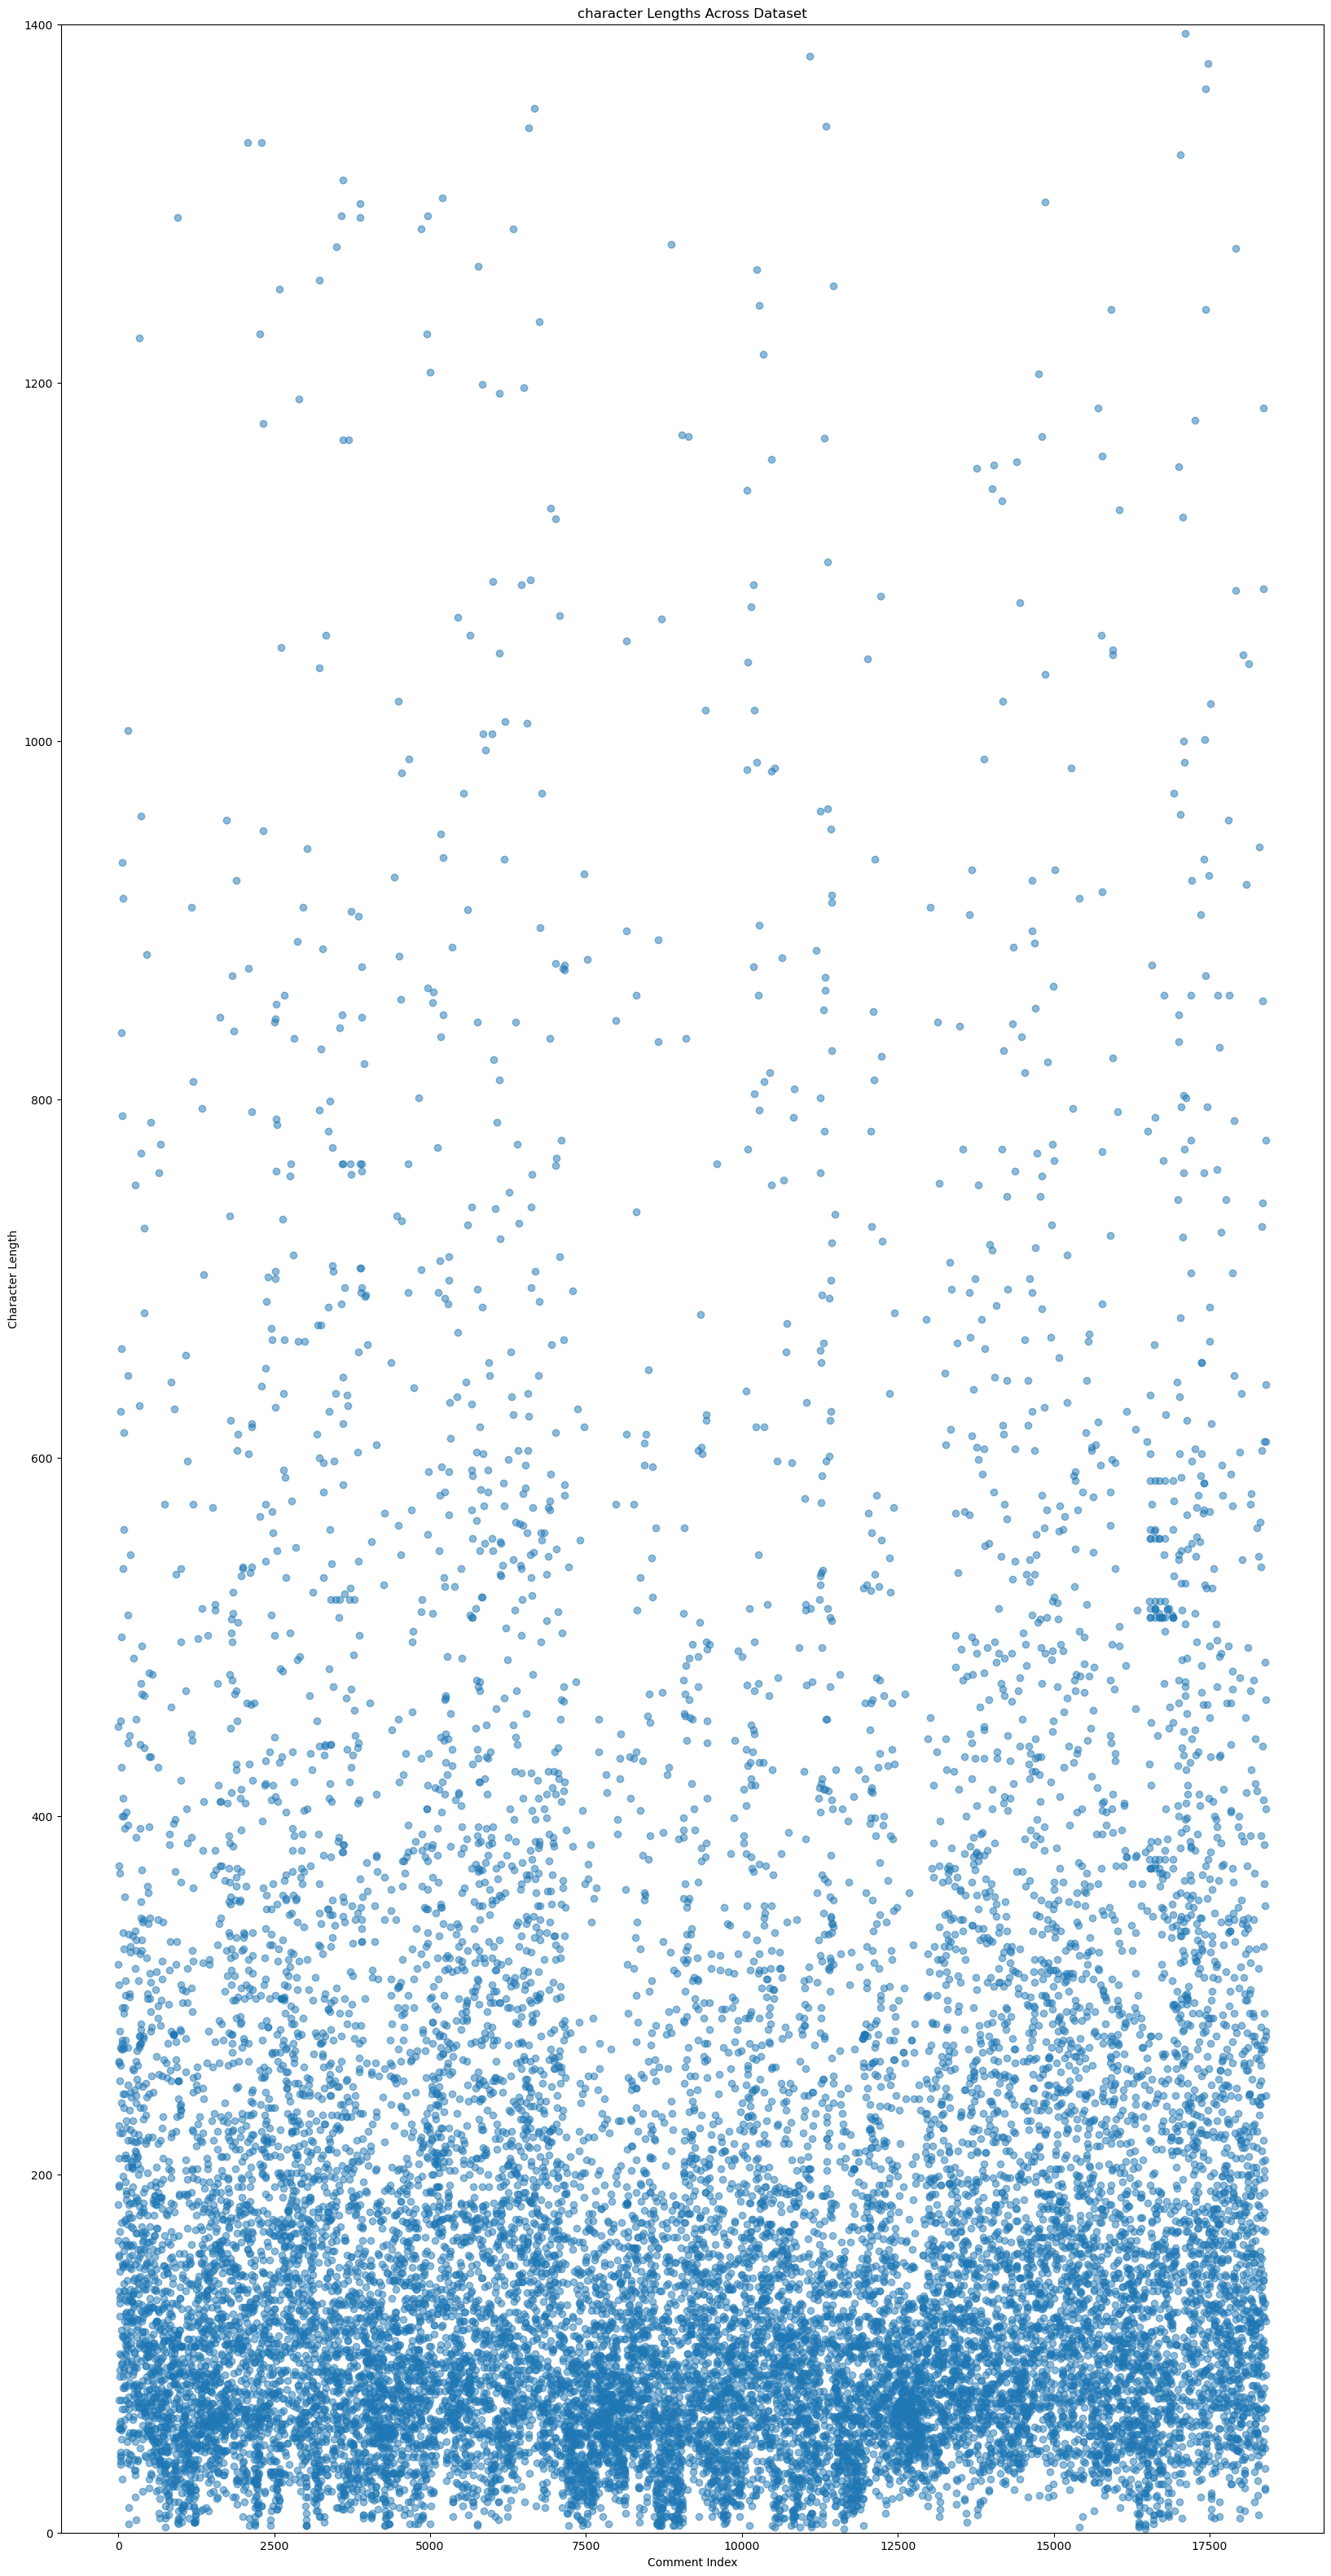

In [46]:
plt.figure(figsize=(20, 40))
plt.scatter(df.index, df['character_count'], alpha=0.5)
plt.xlabel('Comment Index')
plt.ylabel('Character Length')
plt.title('character Lengths Across Dataset')
plt.ylim(0, 1400)  # Set max limit near your longest comment
plt.show()


Mean Sentence Length

In [47]:
nlp = spacy.load("en_core_web_sm")


In [48]:
df['Mean_sent_length']=df['Comment'].apply(lambda x: np.mean([len(sent) for sent in nlp(x).sents]))

C:\Users\Saad\AppData\Local\Temp\ipykernel_10972\2367019160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean_sent_length']=df['Comment'].apply(lambda x: np.mean([len(sent) for sent in nlp(x).sents]))


In [49]:
print(df['Mean_sent_length'].mode())
print(df['Mean_sent_length'].max())

0    14.0
Name: Mean_sent_length, dtype: float64
884.0


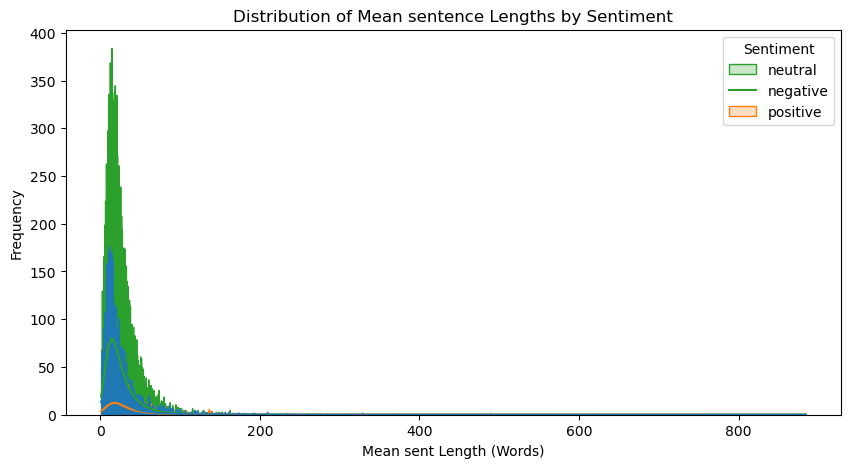

In [50]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='Mean_sent_length', bins=4000, kde=True, hue='Sentiment', element='step', common_norm=False)

plt.xlabel('Mean sent Length (Words)')
plt.ylabel('Frequency')
plt.title('Distribution of Mean sentence Lengths by Sentiment')
plt.legend(title='Sentiment', labels=df['Sentiment'].unique(), fontsize=10)
plt.show()

Term Frequency Analysis
    ,Lowercase
    ,Remove punctutations
    ,Stopword removal

In [51]:
def clean(review):
    
    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])
    
    return review

In [52]:
df['Comment'] = df['Comment'].apply(clean)
df.head(10)

C:\Users\Saad\AppData\Local\Temp\ipykernel_10972\2354342631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Comment'] = df['Comment'].apply(clean)


,Comment,Sentiment,Comment_Length,character_count,Mean_sent_length
0,lets forget apple pay 2014 required brand new ...,neutral,57,317,58.0
1,nz 50 retailers dont even contactless credit c...,negative,29,163,31.0
2,forever acknowledge channel help lessons ideas...,positive,31,183,32.0
3,whenever go place doesnt take apple pay doesnt...,negative,83,450,92.0
4,apple pay convenient secure easy use used kore...,positive,26,135,26.0
5,weve hounding bank adopt apple pay understand ...,neutral,32,155,34.0
6,got apple pay south africa 20202021 widely acc...,positive,14,74,15.0
7,need apple pay physical credit card,neutral,12,58,12.0
8,united states abundance retailers accept apple...,positive,40,209,40.0
9,cambodia universal qr code system scan send mo...,neutral,42,227,42.0


N gram analysis

In [54]:
stop_words = set(stopwords.words("english"))           

def get_top_ngrams(text_series, n=2, top_n=20):
    words = " ".join(text_series).split()
    n_grams = list(ngrams(words, n))
    return Counter(n_grams).most_common(top_n)




In [55]:
uni_gram = get_top_ngrams(df["Comment"], n=1)
word1, count1 = zip(*uni_gram)

bi_gram = get_top_ngrams(df["Comment"], n=2)
word2, count2 = zip(*bi_gram)

tri_gram = get_top_ngrams(df["Comment"], n=3)
word3, count3 = zip(*tri_gram)

In [56]:
# Convert tuples into proper space-separated words
word1, count1 = zip(*[(" ".join(w), c) for w, c in uni_gram])
word2, count2 = zip(*[(" ".join(w), c) for w, c in bi_gram])
word3, count3 = zip(*[(" ".join(w), c) for w, c in tri_gram])


C:\Users\Saad\AppData\Local\Temp\ipykernel_10972\3633796332.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count1, y=(word1), ax=axes[0], palette="Blues_r")
C:\Users\Saad\AppData\Local\Temp\ipykernel_10972\3633796332.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count2, y=word2, ax=axes[1], palette="Greens_r")
C:\Users\Saad\AppData\Local\Temp\ipykernel_10972\3633796332.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count3, y=word3, ax=axes[2], palette="Reds_r")


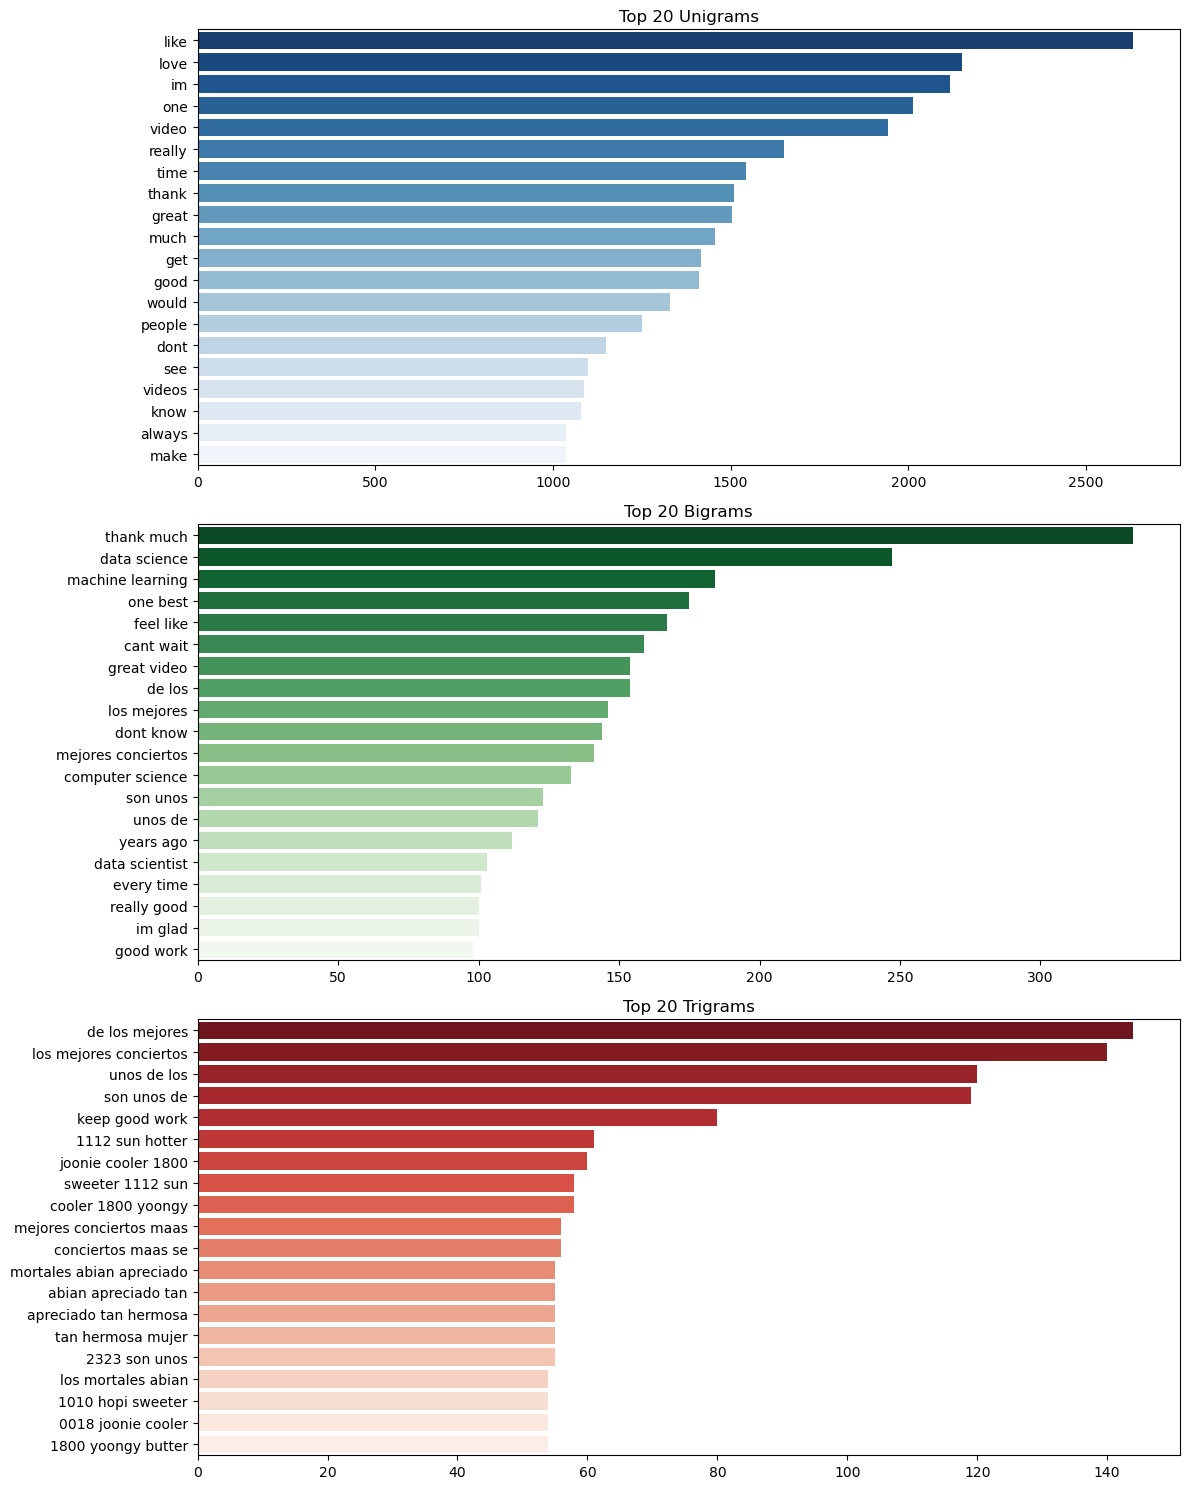

In [57]:
word1, count1 = list(word1), list(count1)
word2, count2 = list(word2), list(count2)
word3, count3 = list(word3), list(count3)

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Plot unigrams
sns.barplot(x=count1, y=(word1), ax=axes[0], palette="Blues_r")
axes[0].set_title("Top 20 Unigrams")

# Plot bigrams
sns.barplot(x=count2, y=word2, ax=axes[1], palette="Greens_r")
axes[1].set_title("Top 20 Bigrams")

# Plot trigrams
sns.barplot(x=count3, y=word3, ax=axes[2], palette="Reds_r")
axes[2].set_title("Top 20 Trigrams")

# Adjust layout
plt.tight_layout()
plt.show()

In [58]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

In [59]:
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)



In [60]:
# Expanding Contractions in the reviews
df['Comment_Without_Contraction']=df['Comment'].apply(lambda x:expand_contractions(x))

C:\Users\Saad\AppData\Local\Temp\ipykernel_10972\2609659495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Comment_Without_Contraction']=df['Comment'].apply(lambda x:expand_contractions(x))


In [78]:
df['Tokens']=df['Comment_Without_Contraction'].apply(lambda x:word_tokenize(x))

C:\Users\Saad\AppData\Local\Temp\ipykernel_10972\2874328484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tokens']=df['Comment_Without_Contraction'].apply(lambda x:word_tokenize(x))


Visualize topic modeling with pyLDAvis

In [81]:
# Create dictionary & corpus for LDA
dictionary = Dictionary(df["Tokens"])
corpus = [dictionary.doc2bow(text) for text in df["Tokens"]]

In [91]:
# print(dictionary.token2id)  

In [87]:
num_topics = 3  # Define number of topics

# Train LDA Model
lda_model = gensim.models.LdaModel(corpus=corpus, 
                                   id2word=dictionary, 
                                   num_topics=num_topics, 
                                   random_state=42, 
                                   passes=10)

# Print the topics
for idx, topic in lda_model.print_topics():
    print(f"Topic {idx}: {topic}")

Topic 0: 0.014*"u" + 0.006*"son" + 0.005*"na" + 0.005*"2" + 0.005*"model" + 0.005*"sat" + 0.005*"los" + 0.004*"se" + 0.004*"2222" + 0.004*"mejores"
Topic 1: 0.009*"like" + 0.009*"video" + 0.008*"thank" + 0.007*"im" + 0.007*"one" + 0.007*"learning" + 0.007*"really" + 0.007*"great" + 0.006*"love" + 0.006*"data"
Topic 2: 0.019*"de" + 0.014*"que" + 0.013*"learning" + 0.007*"la" + 0.007*"el" + 0.007*"en" + 0.004*"machine" + 0.004*"e" + 0.004*"es" + 0.004*"por"


In [88]:
# Prepare visualization
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)



In [90]:
pyLDAvis.display(lda_vis)  # Use in Jupyter Notebook